# Final Arc

In [1]:
# General
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Prepo 1 (Visualisasi)
import missingno as mno
from fast_ml.feature_selection import get_duplicate_features

# Prepo 2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import FunctionTransformer

# Model
from imblearn.over_sampling import ADASYN
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, make_scorer, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
feature = pd.read_csv(r'C:\Users\daffa\OneDrive - UGM 365\Keperluan Lomba\ICONIC\Iconic_2024\Dataset\Ekonomi\Credit_card.csv') 
label = pd.read_csv(r'C:\Users\daffa\OneDrive - UGM 365\Keperluan Lomba\ICONIC\Iconic_2024\Dataset\Ekonomi\Credit_card_label.csv')

In [3]:
# Gabungkan data feature dengan label dengan Ind_ID
data = pd.merge(feature, label, on='Ind_ID')
data

,Ind_ID,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members,label
0,5008827,M,Y,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,-18772.0,365243,1,0,0,0,NaN,2,1
1,5009744,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
2,5009746,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,NaN,-586,1,1,1,0,NaN,2,1
3,5009749,F,Y,N,0,NaN,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
4,5009752,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,5028645,F,N,Y,0,NaN,Commercial associate,Higher education,Married,House / apartment,-11957.0,-2182,1,0,0,0,Managers,2,0
1544,5023655,F,N,N,0,225000.0,Commercial associate,Incomplete higher,Single / not married,House / apartment,-10229.0,-1209,1,0,0,0,Accountants,1,0
1545,5115992,M,Y,Y,2,180000.0,Working,Higher education,Married,House / apartment,-13174.0,-2477,1,0,0,0,Managers,4,0
1546,5118219,M,Y,N,0,270000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-15292.0,-645,1,1,1,0,Drivers,2,0


In [4]:
# Menghapus kolom Ind_ID
data = data.drop(columns=['Ind_ID'])

In [5]:
# Ubah tipe Mobile_phone, Work_phone, Phone, Email, dan label menjadi kategori
data['Mobile_phone'] = data['Mobile_phone'].astype('category')
data['Work_Phone'] = data['Work_Phone'].astype('category')
data['Phone'] = data['Phone'].astype('category')
data['EMAIL_ID'] = data['EMAIL_ID'].astype('category')
data['label'] = data['label'].astype('category')

data = data.drop(columns=['Mobile_phone'])
data = data.drop(columns=['Propert_Owner'])

In [6]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np

X = data.drop(columns="label")
y = data["label"]

# Define the feature engineering function
def feature_engineering(df):
    df["Years_Employed"] = df["Employed_days"] // 365
    df["Birthday_count"] = df["Birthday_count"].abs()
    df["Income_per_Family_Member"] = df["Annual_income"] / df["Family_Members"]
    df["Children_per_Family_Member"] = df["CHILDREN"] / df["Family_Members"]
    df["Is_Employed"] = df["Employed_days"] > 0
    return df

# Create the FunctionTransformer
feature_engineering_transformer = FunctionTransformer(feature_engineering)

# Update the feature lists
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

# Define the numeric transformer
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

# Define the categorical transformer
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Define the preprocessor with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Create and apply pipeline
pipeline = Pipeline(
    steps=[
        ("feature_engineering", feature_engineering_transformer),
        ("preprocessor", preprocessor),
    ]
)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Preprocess the data
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

In [8]:
from sklearn.metrics import roc_curve, classification_report, confusion_matrix

# Calculate geometric mean for each threshold
def geometric_mean(sensitivity, specificity):
    return np.sqrt(sensitivity * specificity)

# Initialize models
models = CatBoostClassifier(random_state=0, silent=True)

# Function to evaluate each model
def evaluate_model(model, X_test_processed, y_test):
    # Fit the model
    model.fit(X_train_processed, y_train)
    
    # Get predicted probabilities for the positive class
    y_probs = model.predict_proba(X_test_processed)[:, 1]

    # Calculate the ROC curve points
    fpr, tpr, thresholds = roc_curve(y_test, y_probs, pos_label=1)

    # Calculate specificity (1 - FPR)
    specificity = 1 - fpr

    # Calculate geometric mean for each threshold
    gmeans = [geometric_mean(tpr[i], specificity[i]) for i in range(len(tpr))]

    # Find the threshold that gives the best geometric mean
    optimal_idx = np.argmax(gmeans)
    optimal_threshold = thresholds[optimal_idx]

    # Make predictions using the optimal threshold
    y_pred = (y_probs >= optimal_threshold).astype(int)

    # Print classification report
    print(f"Classification Report for {model.__class__.__name__}:")
    print(classification_report(y_test, y_pred, digits=3))

    # Plot the confusion matrix heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model.__class__.__name__}')
    plt.show()

# Evaluate all models
evaluate_model(models, X_test, y_test)


CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=0]="F": Cannot convert 'b'F'' to float

Classification Report for CatBoostClassifier:
              precision    recall  f1-score   support

           0      0.970     0.796     0.875       280
           1      0.287     0.767     0.418        30

    accuracy                          0.794       310
   macro avg      0.629     0.782     0.646       310
weighted avg      0.904     0.794     0.830       310



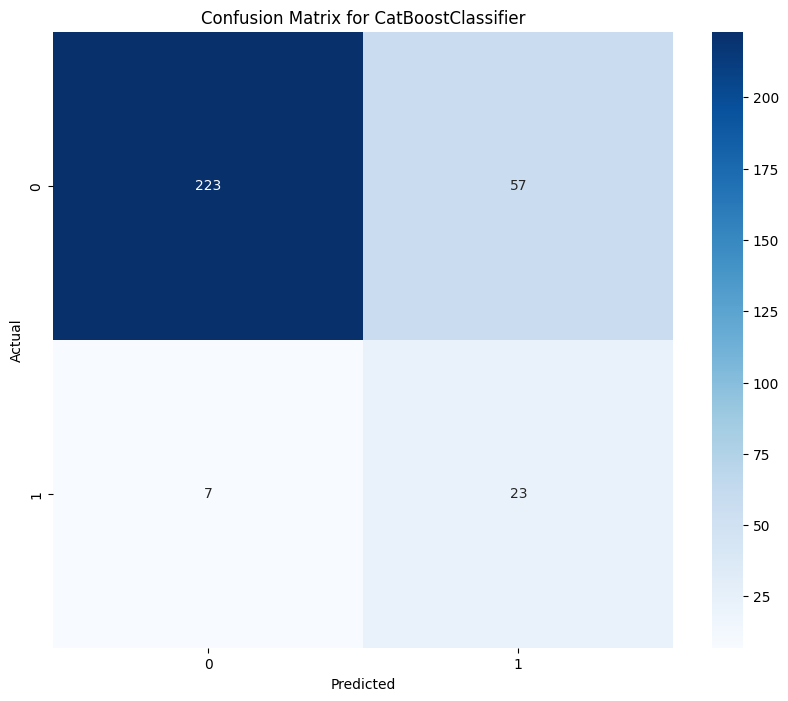

In [9]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix
from catboost import CatBoostClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Misalkan 'data' adalah DataFrame yang telah disiapkan
X = data.drop(columns="label")
y = data["label"]

# Define the feature engineering function
def feature_engineering(df):
    df["Years_Employed"] = df["Employed_days"] // 365
    df["Birthday_count"] = df["Birthday_count"].abs()
    df["Income_per_Family_Member"] = df["Annual_income"] / df["Family_Members"]
    df["Children_per_Family_Member"] = df["CHILDREN"] / df["Family_Members"]
    df["Is_Employed"] = df["Employed_days"] > 0
    return df

# Create the FunctionTransformer
feature_engineering_transformer = FunctionTransformer(feature_engineering)

# Update the feature lists
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

# Define the numeric transformer
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

# Define the categorical transformer
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Define the preprocessor with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Create and apply pipeline
pipeline = Pipeline(
    steps=[
        ("feature_engineering", feature_engineering_transformer),
        ("preprocessor", preprocessor),
    ]
)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Preprocess the data
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

# Define the geometric mean function
def geometric_mean(sensitivity, specificity):
    return np.sqrt(sensitivity * specificity)

# Initialize model
model = CatBoostClassifier(random_state=0, silent=True)

# Function to evaluate the model
def evaluate_model(model, X_train_processed, X_test_processed, y_train, y_test):
    # Fit the model
    model.fit(X_train_processed, y_train)
    
    # Get predicted probabilities for the positive class
    y_probs = model.predict_proba(X_test_processed)[:, 1]

    # Calculate the ROC curve points
    fpr, tpr, thresholds = roc_curve(y_test, y_probs, pos_label=1)

    # Calculate specificity (1 - FPR)
    specificity = 1 - fpr

    # Calculate geometric mean for each threshold
    gmeans = [geometric_mean(tpr[i], specificity[i]) for i in range(len(tpr))]

    # Find the threshold that gives the best geometric mean
    optimal_idx = np.argmax(gmeans)
    optimal_threshold = thresholds[optimal_idx]

    # Make predictions using the optimal threshold
    y_pred = (y_probs >= optimal_threshold).astype(int)

    # Print classification report
    print(f"Classification Report for {model.__class__.__name__}:")
    print(classification_report(y_test, y_pred, digits=3))

    # Plot the confusion matrix heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model.__class__.__name__}')
    plt.show()

# Evaluate the model
evaluate_model(model, X_train_processed, X_test_processed, y_train, y_test)


In [ ]:
data['Car_Owner'].unique()

array(['Y', 'N'], dtype=object)

In [ ]:
import joblib

# Load the model
model = joblib.load("CatBoost_final.pkl")

# Print the model's expected features
print(model.feature_names_)

FileNotFoundError: [Errno 2] No such file or directory: 'CatBoost_final.pkl'

In [ ]:
data['Work_Phone'].unique()

[0, 1]
Categories (2, int64): [0, 1]

In [ ]:
data['Phone'].unique()

[0, 1]
Categories (2, int64): [0, 1]

In [ ]:
data['EMAIL_ID'].unique()

[0, 1]
Categories (2, int64): [0, 1]

In [ ]:
pipeline

Pipeline(steps=[('feature_engineering',
                 FunctionTransformer(func=<function feature_engineering at 0x00000154F0DBD8A0>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CHILDREN', 'Annual_income',
                                                   'Birthday_count',
                                                   'Employed_days',
                                                   'Family_Members']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['GENDER', 'Car_Owner',
                                                   'Type_Income', 'EDUCATION',
                                                   'Marital_status',
                                                   'Housing_type', 'Work_Phone',
                                                   'Phone', 'EMAIL_ID',
                                                   'Type_Occupation'])]))])

In [ ]:
import joblib

# Assuming 'pipeline' is your preprocessing pipeline and 'xgb_model' is your trained model

# Save the preprocessing pipeline
joblib.dump(pipeline, 'preprocessing_pipeline_ulang.pkl')

['preprocessing_pipeline_ulang.pkl']

In [ ]:
input_df = get_user_input()

# Ensure the required feature is present
required_feature = 'Type_Occupation_Secretaries'
if required_feature not in input_df.columns:
    input_df[required_feature] = 0  # or another appropriate default value

# Preprocess the input data
input_processed = pipeline.transform(input_df)

# Load the model
model = joblib.load("CatBoost_final_2.pkl")

# Make predictions
prediction = model.predict(input_processed)
prediction_prob = model.predict_proba(input_processed)

# Display the prediction and probabilities
st.write(f"Prediction: {'Positive' if prediction[0] == 1 else 'Negative'}")
st.write(f"Prediction Probability: {prediction_prob[0]}")

if __name__ == "__main__":
    main()

NameError: name 'get_user_input' is not defined